In [1]:
MONK_TASK = 3
USER = 'Paolo'

In [2]:
import sys
import os
if (colab := 'google.colab' in sys.modules):
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_PATH = '/content/drive/Shareddrives/Project_ML_23/' + USER + '/machine-learning-project'
    sys.path.insert(0,BASE_PATH)
    N_JOBS = 1
    sys.path.insert(0,BASE_PATH + '/src/utils')
    !pip install optuna
    !pip install scikit-learn
    !pip install scikeras
    TRAIN_DATA = os.path.join(BASE_PATH, 'datasets', 'monk',f'monks-{MONK_TASK}.train')
    TEST_DATA = os.path.join(BASE_PATH, 'datasets', 'monk',f'monks-{MONK_TASK}.test')
    IMAGES_FOLDER = os.path.join(BASE_PATH, 'images', 'monk',  f'task-{MONK_TASK}', 'neural_network')
    MODEL_FOLDER = os.path.join(BASE_PATH, 'trained_models', 'monk', f'task-{MONK_TASK}')
else :
    TRAIN_DATA = os.path.join('..', '..', '..', 'datasets', 'monk', f'monks-{MONK_TASK}.train')
    TEST_DATA = os.path.join('..', '..', '..', 'datasets', 'monk', f'monks-{MONK_TASK}.test')
    N_JOBS = -1
    IMAGES_FOLDER = os.path.join('..', '..', '..', 'images', 'monk', f'task-{MONK_TASK}', 'neural_network')
    MODEL_FOLDER = os.path.join('..', '..', '..', 'trained_models', 'monk', f'task-{MONK_TASK}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
if (colab := 'google.colab' in sys.modules):
    sys.path.append(BASE_PATH + '/src/utils')
else:
    sys.path.append('../../utils')

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns; sns.set_theme(style='darkgrid')

from utils import save_plot, set_random_state
from NN import MonkNeuralNetwork

set_random_state(42)

In [4]:
# To skip the first column (row indexes)
columns_to_read = list(range(1, 8))

df_train = pd.read_csv(TRAIN_DATA, header=None, usecols=columns_to_read, delimiter=' ')
df_test = pd.read_csv(TEST_DATA, header=None, usecols=columns_to_read, delimiter=' ')
df_train.head()

,1,2,3,4,5,6,7
0,1,1,1,1,1,1,2
1,1,1,1,1,1,2,1
2,1,1,1,1,1,2,2
3,0,1,1,1,1,3,1
4,0,1,1,1,1,4,1


In [5]:
features = ['feature_' + str(i) for i in range(1, 7)]

# Rename columns
new_column_names = ['class'] + features

df_train.columns = new_column_names
df_test.columns = new_column_names

df_train.head()

,class,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6
0,1,1,1,1,1,1,2
1,1,1,1,1,1,2,1
2,1,1,1,1,1,2,2
3,0,1,1,1,1,3,1
4,0,1,1,1,1,4,1


In [6]:
df_train_encoded = pd.get_dummies(df_train, columns=features)
df_test_encoded = pd.get_dummies(df_test, columns=features)

df_train_encoded, df_test_encoded = df_train_encoded.align(df_test_encoded, join='inner', axis=1)

df_train_encoded.head()

,class,feature_1_1,feature_1_2,feature_1_3,feature_2_1,feature_2_2,feature_2_3,feature_3_1,feature_3_2,feature_4_1,feature_4_2,feature_4_3,feature_5_1,feature_5_2,feature_5_3,feature_5_4,feature_6_1,feature_6_2
0,1,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1
1,1,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0
2,1,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1
3,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0
4,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,1,0


In [7]:
features = df_train_encoded.columns.difference(['class'])

X_train = df_train_encoded[features].to_numpy()
y_train = df_train_encoded['class'].to_numpy()

X_test = df_test_encoded[features].to_numpy()
y_test = df_test_encoded['class'].to_numpy()

# Create model

In [8]:
model = MonkNeuralNetwork(input_dim=X_train.shape[1], verbose=0)

In [9]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'architecture': [
        (8,), (8, 8), (8, 8, 8), (8, 8, 8, 8)
    ],
    'optimizer': ['sgd'],
    'activation': ['relu'],
    'learning_rate': [0.1, 0.3, 0.5],
    'momentum': [0.6, 0.8, 0.9],
    'lambda_value': [0.01],
    'epochs': [200],
    'batch_size': [8],
    'patience': [6]
}
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    n_jobs=N_JOBS,
    verbose=0,
    scoring='accuracy'
)

grid_search.fit(X_train, y_train)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 206ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 74ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 106ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 67ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 48ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 49ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 45ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 46ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 53ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 44ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 45ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 44ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 44ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 69ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 70ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 66ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 44ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 42ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 51ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 47ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 44ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 48ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 72ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 48ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 45ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 57ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 44ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 46ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 41ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 43ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 48ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 71ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 66ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 47ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 46ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 44ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 43ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 47ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 43ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 45ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 49ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 62ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 70ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 45ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 45ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 58ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 52ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 84ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 52ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 59ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 48ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 68ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 88ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 51ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 53ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 53ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 48ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 50ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 84ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 79ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 54ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 47ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 50ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 52ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 56ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 48ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 79ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 75ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 48ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 51ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 48ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 53ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 58ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 55ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 86ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 71ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 70ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 51ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 57ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 60ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 54ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 51ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 87ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 86ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 51ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 60ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 54ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 55ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 50ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 49ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 60ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 61ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 93ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 89ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 60ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 60ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 69ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 61ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 94ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 58ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 63ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 55ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 57ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 70ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 93ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 58ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 58ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 57ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 58ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 57ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 63ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 100ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 83ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 102ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 55ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 58ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 57ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 55ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 60ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 58ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 86ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 90ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 291ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 137ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 101ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 79ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 92ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 93ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 54ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 57ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 59ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 60ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 76ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 59ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 86ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 80ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 74ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 64ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 64ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 67ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 93ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 91ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 63ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 232ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 65ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 64ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 97ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 99ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 60ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 64ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 66ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 66ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 97ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 100ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 61ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 65ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 63ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 65ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 59ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 97ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 85ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 61ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 61ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 60ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 69ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 62ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 95ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 64ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 76ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 69ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 66ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 106ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 106ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 100ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 68ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 66ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 65ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 77ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 69ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 104ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

GridSearchCV(cv=5, estimator=MonkNeuralNetwork(verbose=0), n_jobs=1,
             param_grid={'activation': ['relu'],
                         'architecture': [(8,), (8, 8), (8, 8, 8),
                                          (8, 8, 8, 8)],
                         'batch_size': [8], 'epochs': [200],
                         'lambda_value': [0.01],
                         'learning_rate': [0.1, 0.3, 0.5],
                         'momentum': [0.6, 0.8, 0.9], 'optimizer': ['sgd'],
                         'patience': [6]},
             scoring='accuracy')

In [10]:
results = grid_search.cv_results_

results_df = pd.DataFrame(results)
csv_filename = f'Monk_NN_{MONK_TASK}.csv'
# results_df.to_csv(csv_filename, index=False)

# Learning curve

In [11]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)
train_scores, test_scores = [], []

best_params = grid_search.best_params_

# Cross-validation con i migliori parametri
for train_index, test_index in cv.split(X_train):
    X_train_1, X_test_1 = X_train[train_index], X_train[test_index]
    y_train_1, y_test_1 = y_train[train_index], y_train[test_index]

    best_model = MonkNeuralNetwork(input_dim=X_train_1.shape[1], verbose=0, **best_params)
    best_model.fit(X_train_1, y_train_1, validation_data=(X_test_1, y_test_1))

    #df = best_model.history.history
    train_scores.append(best_model.history.history)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [12]:
train_scores_df = pd.DataFrame(train_scores)
train_scores_filename = f'Monk_NN_{MONK_TASK}_train_scores.csv'
# train_scores_df.to_csv(train_scores_filename, index=False)

train_scores_df['val_loss']

0    [0.4230525493621826, 0.40164557099342346, 0.37...
1    [0.4277278780937195, 0.39944201707839966, 0.37...
2    [0.40239763259887695, 0.3720569610595703, 0.33...
3    [0.3971162736415863, 0.368279367685318, 0.3440...
4    [0.407259076833725, 0.38010773062705994, 0.353...
Name: val_loss, dtype: object

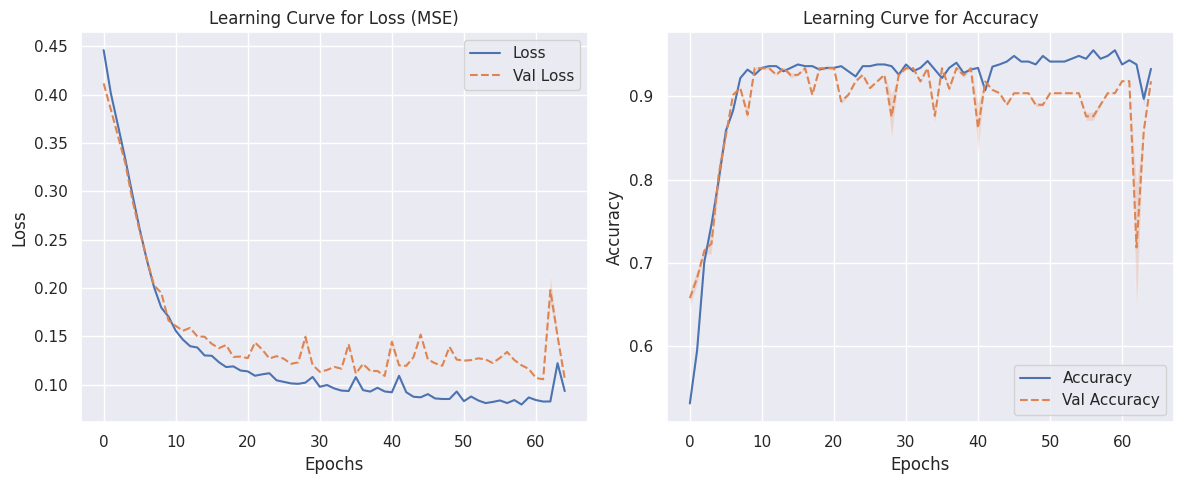

In [13]:
loss, val_loss, acc, val_acc = [], [], [], []

for i in range(len(train_scores_df)):
    loss.append(train_scores_df.iloc[i]['loss'])
    val_loss.append(train_scores_df.iloc[i]['val_loss'])
    acc.append(train_scores_df.iloc[i]['binary_accuracy'])
    val_acc.append(train_scores_df.iloc[i]['val_binary_accuracy'])

df_loss = pd.DataFrame(loss).T
df_val_loss = pd.DataFrame(val_loss).T
df_acc = pd.DataFrame(acc).T
df_val_acc = pd.DataFrame(val_acc).T

mean_loss = df_loss.mean(axis=1)
var_loss = df_loss.var(axis=1)
mean_val_loss = df_val_loss.mean(axis=1)
var_val_loss = df_val_loss.var(axis=1)

mean_acc = df_acc.mean(axis=1)
var_acc = df_acc.var(axis=1)
mean_val_acc = df_val_acc.mean(axis=1)
var_val_acc = df_val_acc.var(axis=1)

plt.figure(figsize=(12, 5))

# loss and val_loss
plt.subplot(1, 2, 1)
plt.plot(mean_loss, label='Loss', linestyle='-')
plt.fill_between(range(len(mean_loss)), mean_loss-var_loss, mean_loss+var_loss, alpha=0.2)
plt.plot(mean_val_loss, label='Val Loss', linestyle='--')
plt.fill_between(range(len(mean_val_loss)), mean_val_loss-var_val_loss, mean_val_loss+var_val_loss, alpha=0.2)
plt.title('Learning Curve for Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# binary_accuracy and val_binary_accuracy
plt.subplot(1, 2, 2)
plt.plot(mean_acc, label='Accuracy', linestyle='-')
plt.fill_between(range(len(mean_acc)), mean_acc-var_acc, mean_acc+var_acc, alpha=0.2)
plt.plot(mean_val_acc, label='Val Accuracy', linestyle='--')
plt.fill_between(range(len(mean_val_acc)), mean_val_acc-var_val_acc, mean_val_acc+var_val_acc, alpha=0.2)
plt.title('Learning Curve for Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
save_plot(plt, IMAGES_FOLDER, 'learning_curve')
plt.show()

# Test model

In [14]:
from sklearn.metrics import accuracy_score, classification_report

# Test set accuracy hold-out

final_model = grid_search.best_estimator_
y_pred = final_model.predict(X_test)

print('Best parameters: ', grid_search.best_params_)
print('Best accuracy: ', grid_search.best_score_)
print('Test set accuracy: ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

14/14 [==============================] - 0s 2ms/step
Best parameters:  {'activation': 'relu', 'architecture': (8, 8), 'batch_size': 8, 'epochs': 200, 'lambda_value': 0.01, 'learning_rate': 0.1, 'momentum': 0.6, 'optimizer': 'sgd', 'patience': 6}
Best accuracy:  0.9339999999999999
Test set accuracy:  0.9722222222222222
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       204
           1       1.00      0.95      0.97       228

    accuracy                           0.97       432
   macro avg       0.97      0.97      0.97       432
weighted avg       0.97      0.97      0.97       432



# Save model

In [15]:
from joblib import dump

model_path = os.path.join(MODEL_FOLDER, 'NN_model.joblib')
dump(final_model, model_path, compress=3)

['/content/drive/Shareddrives/Project_ML_23/Paolo/machine-learning-project/trained_models/monk/task-3/NN_model.joblib']